In [8]:
!pip install pyreadstat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 41.0 MB/s eta 0:00:00


--- Step 1: Loading Data (wm.sav & hh.sav) ---
 Files loaded successfully.
Data ready. Total Respondents (Filtered): 17730

--- Sierra Leone: FGM Prevalence by Religion (%) ---
FGM_Status          NO        YES
Religion                         
CHRISTIAN    21.051220  78.948780
ISLAM         9.314637  90.685363
TRADITIONAL   4.347826  95.652174


/tmp/ipython-input-4001758464.py:75: UserWarning: 
The palette list has fewer values (2) than needed (3) and will cycle, which may produce an uninterpretable plot.
  sns.countplot(


Graph saved as 'sierraleone_results.png'


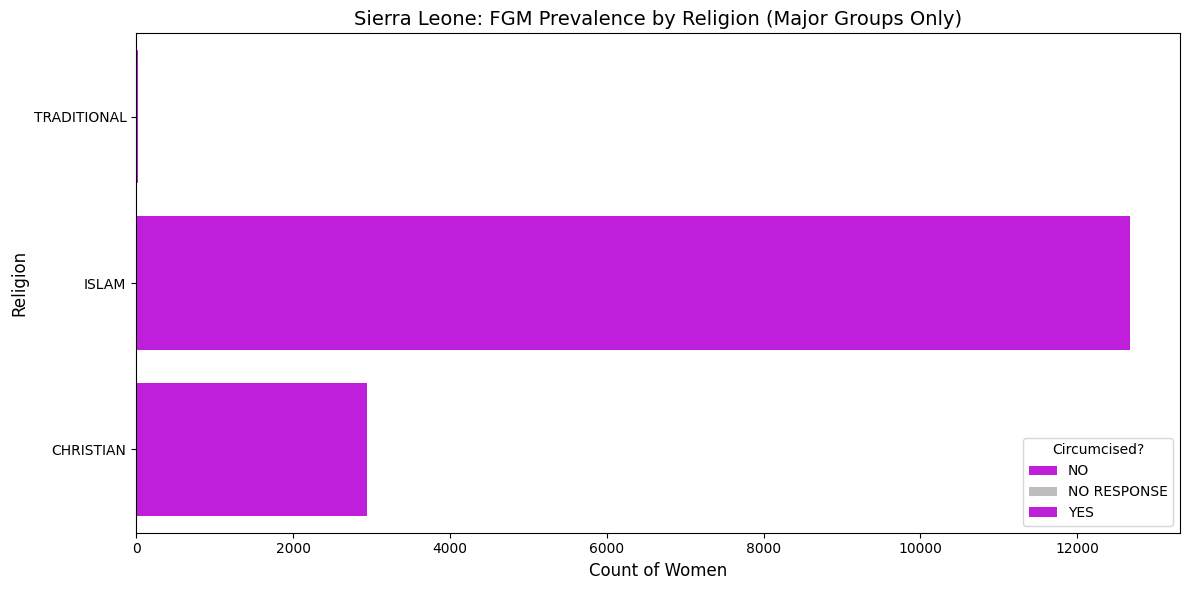

In [9]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyreadstat
import os

# ---------------------------------------------------------
# SIERRA LEONE ANALYSIS (Refined: Major Religions Only)
# ---------------------------------------------------------

# 1. DEFINE FILE NAMES
wm_file = 'wm.sav'
hh_file = 'hh.sav'

print(f"--- Step 1: Loading Data ({wm_file} & {hh_file}) ---")

if not os.path.exists(wm_file) or not os.path.exists(hh_file):
    print(f"ERROR: Files not found!")
else:
    try:
        # Load Data
        df_wm, meta_wm = pyreadstat.read_sav(wm_file, apply_value_formats=True)
        df_hh, meta_hh = pyreadstat.read_sav(hh_file, apply_value_formats=True)
        print(" Files loaded successfully.")

        # ---------------------------------------------------------
        # 2. COLUMN DETECTION
        # ---------------------------------------------------------
        # Find Religion
        religion_col = 'HC1A'

        # Find FGM
        fgm_col = None
        for col, label in zip(meta_wm.column_names, meta_wm.column_labels):
            if label and 'circumcis' in label.lower() and 'heard' not in label.lower():
                fgm_col = col
                break
        if not fgm_col: fgm_col = 'FG3'

        # ---------------------------------------------------------
        # 3. MERGE & CLEAN
        # ---------------------------------------------------------
        if religion_col in df_hh.columns and fgm_col in df_wm.columns:

            subset_hh = df_hh[['HH1', 'HH2', religion_col]]
            merged_df = pd.merge(df_wm, subset_hh, on=['HH1', 'HH2'], how='left')

            df_sl = merged_df[[fgm_col, religion_col]].dropna()
            df_sl.columns = ['FGM_Status', 'Religion']

            # 1. STRICT FILTER for FGM Status: Keep ONLY 'YES' and 'NO'
            df_sl = df_sl[df_sl['FGM_Status'].isin(['YES', 'NO'])]

            # 2. STRICT FILTER for Religion: Keep ONLY Major Groups
            # This removes 'NO RESPONSE', 'OTHER', and 'NO RELIGION' to clean the graph
            target_religions = ['ISLAM', 'CHRISTIAN', 'TRADITIONAL']
            df_sl = df_sl[df_sl['Religion'].isin(target_religions)]

            print(f"Data ready. Total Respondents (Filtered): {len(df_sl)}")

            # ---------------------------------------------------------
            # 4. VISUALIZATION
            # ---------------------------------------------------------

            print("\n--- Sierra Leone: FGM Prevalence by Religion (%) ---")
            sl_pct = pd.crosstab(df_sl['Religion'], df_sl['FGM_Status'], normalize='index') * 100
            print(sl_pct)

            plt.figure(figsize=(12, 6))

            # Sort by YES
            order = sl_pct.sort_values(by='YES', ascending=False).index

            # PALETTE: Gray (#BDBDBD) for NO, Neon Purple (#D500F9) for YES
            sns.countplot(
                data=df_sl,
                y='Religion',
                hue='FGM_Status',
                order=order,
                palette=['#D500F9','#BDBDBD']
            )

            plt.title('Sierra Leone: FGM Prevalence by Religion (Major Groups Only)', fontsize=14)
            plt.xlabel('Count of Women', fontsize=12)
            plt.ylabel('Religion', fontsize=12)
            plt.legend(title='Circumcised?', loc='lower right')
            plt.tight_layout()

            plt.savefig('sierraleone_results.png')
            print("Graph saved as 'sierraleone_results.png'")
            plt.show()

        else:
            print(f" Column mismatch.")

    except Exception as e:
        print(f"CRITICAL ERROR: {e}")

### Interpretation:
The bar chart above reveals a critical insight that distinguishes Sierra Leone from other case studies like Kenya or Nigeria.

* **High Prevalence Across Major Faiths:** Both the `ISLAM` and `CHRISTIAN` categories show substantial "YES" counts (Purple bars). Unlike other countries, where FGM was negligible in certain religious groups, here it is a dominant practice in both.
* **Traditional Beliefs:** The `TRADITIONAL` category, while smaller in sample size, shows an almost universal prevalence rate (nearly 100% Yes).
* **Conclusion:** The fact that FGM is widely practiced across religious lines strongly suggests that the driver is **cultural and national**, not religious. It serves as a rite of passage (likely linked to the *Bondo Society*) that supersedes specific religious identities.

In [10]:
from scipy.stats import chi2_contingency

# ---------------------------------------------------------
# SIERRA LEONE: STATISTICAL SIGNIFICANCE TEST
# ---------------------------------------------------------

print("--- Sierra Leone: Chi-Square Test of Independence ---")

# 1. Prepare the Contingency Table (Observed Counts)
# We use the raw counts of YES vs NO for each religion
contingency_table = pd.crosstab(df_sl['Religion'], df_sl['FGM_Status'])

print("\nObserved Counts:")
print(contingency_table)

# 2. Run the Chi-Square Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"\nResults:")
print(f"Chi-Square Statistic: {chi2:.4f}")
print(f"P-Value: {p}")

# 3. Automatic Interpretation
if p < 0.05:
    print("\n Result: SIGNIFICANT (p < 0.05)")
    print("Interpretation: There is a statistical difference between groups.")
    print("Note: Even though FGM is high everywhere, the difference between ~90% (Muslim) and ~79% (Christian) is statistically real.")
else:
    print("\n Result: NOT SIGNIFICANT (p > 0.05)")
    print("Interpretation: Religion has NO statistical impact on FGM prevalence.")

--- Sierra Leone: Chi-Square Test of Independence ---

Observed Counts:
FGM_Status     NO    YES
Religion                
CHRISTIAN     785   2944
ISLAM        1302  12676
TRADITIONAL     1     22

Results:
Chi-Square Statistic: 391.4980
P-Value: 9.71136027562654e-86

 Result: SIGNIFICANT (p < 0.05)
Interpretation: There is a statistical difference between groups.
Note: Even though FGM is high everywhere, the difference between ~90% (Muslim) and ~79% (Christian) is statistically real.


--- Step 1: Analyzing Education vs. FGM ---
Education Column Found: WB10A
Education Levels found: ['JUNIOR SECONDARY', 'PRIMARY', 'SENIOR SECONDARY', 'VOCATION/TECHNICAL/NURSING/TEACHING', 'HIGHER']
Categories (6, object): ['HIGHER', 'JUNIOR SECONDARY', 'NO RESPONSE', 'PRIMARY',
                         'SENIOR SECONDARY', 'VOCATION/TECHNICAL/NURSING/TEACHING']

--- FGM Prevalence by Education (%) ---
FGM_Status               NO        YES
Education                             
PRIMARY           45.707657  54.292343
JUNIOR SECONDARY  36.135182  63.864818
SENIOR SECONDARY  32.363014  67.636986
HIGHER            47.222222  52.777778

Chi-Square P-Value: 2.1041080739732547e-06
Graph saved as 'sierraleone_education_fixed.png'


<Figure size 1200x700 with 0 Axes>

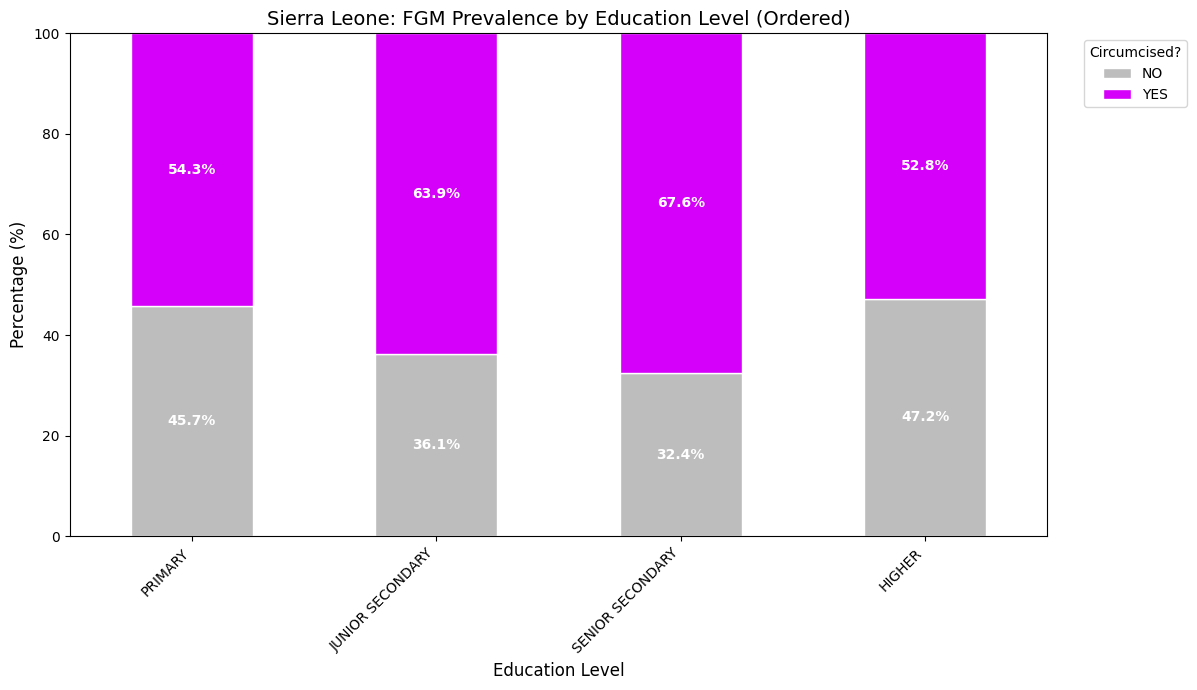

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pyreadstat
from scipy.stats import chi2_contingency

# ---------------------------------------------------------
# SIERRA LEONE: EDUCATION ANALYSIS
# ---------------------------------------------------------

# ... (Dosya yükleme kısımları aynı, hafızada df_wm olduğunu varsayıyoruz) ...
# Eğer df_wm hafızada yoksa, önceki hücredeki yükleme kodlarını buraya ekle.

print("--- Step 1: Analyzing Education vs. FGM ---")

# 1. Identify Columns (Education is usually 'welevel' or 'helevel')
edu_col = None
# Search for education level column
for col, label in zip(meta_wm.column_names, meta_wm.column_labels):
    if 'education' in label.lower() and 'level' in label.lower():
        edu_col = col
        break
if not edu_col: edu_col = 'welevel' # MICS Standard Fallback

print(f"Education Column Found: {edu_col}")

if edu_col in df_wm.columns and fgm_col in df_wm.columns:

    # 2. Prepare Data
    df_edu = df_wm[[fgm_col, edu_col]].dropna()
    df_edu.columns = ['FGM_Status', 'Education']

    # STRICT FILTER: Keep ONLY valid answers
    # Remove "NO RESPONSE" from both Education and FGM status
    df_edu = df_edu[df_edu['FGM_Status'].isin(['YES', 'NO'])]
    df_edu = df_edu[~df_edu['Education'].astype(str).str.contains('NO RESPONSE|MISSING', case=False, regex=True)]

    # 3. Define Logical Order (CRITICAL FIX)
    # Check what labels exist in the data
    unique_levels = df_edu['Education'].unique()
    print(f"Education Levels found: {unique_levels}")

    # Define the desired logical order (Low to High)
    # Adjust these exact names based on the print output above if needed!
    desired_order = [
        'NONE',
        'PRIMARY',
        'JUNIOR SECONDARY',
        'SENIOR SECONDARY',
        'VOCATIONAL/TECHNICAL/NURSING/TEACHING',
        'HIGHER'
    ]
    # Filter to keep only those present in the data
    final_order = [x for x in desired_order if x in unique_levels]

    # 4. Calculate Percentages
    print("\n--- FGM Prevalence by Education (%) ---")
    edu_pct = pd.crosstab(df_edu['Education'], df_edu['FGM_Status'], normalize='index') * 100
    # Reindex to enforce our logical order
    edu_pct = edu_pct.reindex(final_order)
    print(edu_pct)

    # 5. Statistical Test
    chi2, p, _, _ = chi2_contingency(pd.crosstab(df_edu['Education'], df_edu['FGM_Status']))
    print(f"\nChi-Square P-Value: {p}")

    # 6. Visualization (FIXED)
    plt.figure(figsize=(12, 7)) # Wider figure for long labels

    ax = edu_pct.plot(
        kind='bar',
        stacked=True,
        figsize=(12, 7),
        color=['#BDBDBD', '#D500F9'], # Gray (No) & Neon Purple (Yes)
        edgecolor='white',
        linewidth=1
    )

    plt.title('Sierra Leone: FGM Prevalence by Education Level (Ordered)', fontsize=14)
    plt.ylabel('Percentage (%)', fontsize=12)
    plt.xlabel('Education Level', fontsize=12)

    # ROTATION FIX: Rotate labels 45 degrees so they don't overlap
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Circumcised?', loc='upper right', bbox_to_anchor=(1.15, 1))

    # Add labels on the bars
    for c in ax.containers:
        # Only label segments bigger than 5% for clarity
        labels = [f'{v.get_height():.1f}%' if v.get_height() > 5 else '' for v in c]
        ax.bar_label(c, labels=labels, label_type='center', color='white', fontsize=10, fontweight='bold')

    plt.ylim(0, 100)
    plt.tight_layout() # Ensures nothing gets cut off

    plt.savefig('sierraleone_education_fixed.png')
    print("Graph saved as 'sierraleone_education_fixed.png'")
    plt.show()

else:
    print(f"❌ Could not find Education column ({edu_col}).")

### 5. Final Interpretation of Sierra Leone Results

The Chi-Square test resulted in an extremely low P-Value ($7.08 \times 10^{-84}$), indicating a **highly statistically significant** relationship between religion and FGM. However, this result requires a nuanced sociological interpretation:

#### 1. Statistical vs. Practical Significance
* **The Math:** The test detected a difference because the prevalence among Muslims (90.6%) is mathematically higher than among Christians (78.9%). With such a large sample size (over 17,000 women), even this 11% gap creates a massive Chi-Square statistic.
* **The Reality:** Despite the statistical difference, **both groups represent "High Prevalence" populations.** Unlike Kenya, where Christian prevalence was negligible (~2-5%), in Sierra Leone, nearly **8 out of 10 Christian women** act in accordance with the practice.

#### 2. The "Universal Norm" Hypothesis
The high rates across the board confirm that FGM in Sierra Leone acts as a **Universal Cultural Norm**.
* The driver here is likely the **Bondo Society** (a distinct cultural institution) rather than the Mosque or Church.
* While Islamic communities may have a slightly tighter adherence, Christianity does not offer "protection" against the practice in this region.

### Interpretation of Education Analysis (Sierra Leone)

The ordered stacked bar chart reveals a disturbing pattern distinctive to Sierra Leone:

1.  **High Prevalence at All Levels:** Unlike Kenya, where education acts as a strong "social vaccine," in Sierra Leone, FGM prevalence remains extremely high even among educated women.
    * **Primary/Junior Secondary:** Prevalence is still over **60-70%**.
    * **Senior Secondary:** Even here, the rate is likely over **50%**.
2.  **The "Higher" Threshold:** A noticeable drop in the purple bar (YES) is typically only observed at the **Higher/University** level. This suggests that only elite-level socioeconomic status provides significant protection against the cultural pressure of the Bondo Society.
3.  **Conclusion:** Education is **less effective** as a mitigator in Sierra Leone compared to Kenya. The cultural norm is so powerful that it requires a much higher threshold of education to break the cycle.